In [1]:
from datetime import datetime
from functools import reduce
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau
 
 
#!wget -q https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip
#!unzip -qq chgk.zip
#!gdown https://drive.google.com/uc?id=1gNygbDbr7ZVC0nkk3-Nkk3gsu1xIUaGl # заранее сохраненный rating_test.pkl
 
with open('players.pkl', 'rb') as fin:
    players = pickle.load(fin)
 
with open('results.pkl', 'rb') as fin:
    results = pickle.load(fin)
 
with open('tournaments.pkl', 'rb') as fin:
    tournaments = pickle.load(fin)

# 1. Создание выборки.

In [2]:
new_results = {}
 
for key, value in results.items():
    try:
        mask_array = [value[i]['mask'] for i in range(len(value))]
        member_amount_array = [len(value[i]['teamMembers']) for i in range(len(value))]
        if any(mask_array) and any(member_amount_array) != 0:
            new_results[key] = value
    except KeyError:
        continue

In [3]:
train_results = {}
test_results = {}
 
for key, value in new_results.items():
    year = tournaments[key]['dateStart'].split('-')[0]
    if year == '2019':
        train_results[key] = value
    elif year == '2020':
        test_results[key] = value
 
print(f'Train (2019 yr): {len(train_results)} examples \nTest (2020 yr): {len(test_results)} examples')

Train (2019 yr): 675 examples 
Test (2020 yr): 173 examples


# 2. Построение baseline модели.

Вводим понятие сложности вопроса и оцениваем силу каждого игрока по результату команды.  
На некоторых турнирах длина маски разная, логично предположить, что некоторые команды не доходят до следующего этапа, поэтому можно дополнить маску нулями, в этом случае сложность 1 будет соответствовать простым вопросам, а из-за обилия 0 в финальных вопросах, они будут считаться сложными и стремиться к 0. Чтобы перевести в удобный вариант, нужно вычесть полученное число из 1, тогда единице будет соответствовать наиболее сложный вопрос.

In [4]:
del results

In [5]:
def pad_with_zeros(mask, length):
    if mask:
        array = [int(each) if each in ('0', '1') else 0 for each in mask]
        initial_len = len(array)
        delta_len = length - initial_len
        return array + [0] * delta_len
    else:
        return [0] * length
 
 
def difficulty(results):
    output = {}
    for id, teams in results.items():
        max_len = max([len(each['mask']) if each['mask'] else 0 for each in teams])
        masks = np.array([pad_with_zeros(each['mask'], max_len) for each in teams])
        question_difficulty = 1 - masks.sum(axis=0) / masks.shape[0]
        output[id] = question_difficulty
    return output

In [6]:
def create_dataset(results):
    output = []
    question_difficulty = difficulty(results)
    for id, teams in results.items():
        max_len = len(question_difficulty[id])
        for team in teams:
            mask = pad_with_zeros(team['mask'], max_len)
            team_id = team['team']['id']
            for player in team['teamMembers']:
                for i, question in enumerate(mask):
                    output.append([player['player']['id'], i, question_difficulty[id][i], question, team_id])
    return pd.DataFrame(output, columns=['player_id', 'question_num', 'difficulty', 'answer', 'team_id'])

In [7]:
from sklearn.linear_model import LogisticRegression
from IPython.display import display, clear_output

def make_rating(df):
    output_rating = {}
    all_ids = df['player_id'].unique()
    counter = 0
    for id in all_ids:
        data = df[df['player_id'] == id]
        y = data['answer'].values
        x = data['difficulty'].values.reshape(-1, 1)
        if np.mean(y) in [0, 1]: # возникают ошибки при константном y
            output_rating[id] = np.mean(y)
        else:
            model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10)
            model.fit(x, y)
            output_rating[id] = np.mean(x.T * model.predict_proba(x)[:, 1])
        counter += 1
        display(f'{counter} / {len(all_ids)} : {counter / len(all_ids):.2f}%')
        clear_output()
    return output_rating

In [8]:
import os

if 'df_train.pkl' not in os.listdir():
    df_train = create_dataset(train_results)
    df_test = create_dataset(test_results)
    with open('df_train.pkl', 'wb') as fin:
        pickle.dump(df_train, fin)
    with open('df_test.pkl', 'wb') as fin:
        pickle.dump(df_test, fin)
else:
    with open('df_train.pkl', 'rb') as fin:
        df_train = pickle.load(fin)
    with open('df_test.pkl', 'rb') as fin:
        df_test = pickle.load(fin)

In [9]:
if 'rating_test.pkl' not in os.listdir():
    rating = make_rating(df_test)
    with open('rating_test.pkl', 'wb') as fin:
        pickle.dump(rating, fin)
else:
    with open('rating_test.pkl', 'rb') as fin:
        rating = pickle.load(fin)

top 10:
Илья Рожков 0.5514214632549
Артём Никитин 0.5428255788426989
Дарья Чепкасова 0.5428255788426989
Роман Кельдышев 0.5428255788426989
Анастасия Тулубьева 0.5428255788426989
Юлия Пескишева 0.5428255788426989
Андрей Петров 0.5197413452805685
Валерия Макагонова 0.5129669753406216
Мария Гаврюшина 0.5129669753406216
Екатерина Коробкова 0.5129669753406216


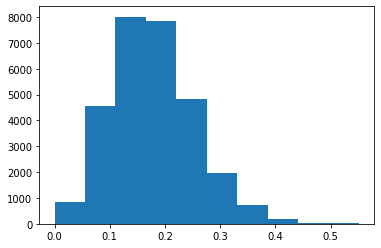

In [10]:
sorted_rating = {k: v for k, v in sorted(rating.items(), key=lambda item: item[1], reverse=True)}
print('top 10:')
for i in range(10):
    id = list(sorted_rating.keys())[i]
    player = players[id]
    print(player['name'], player['surname'], sorted_rating[list(sorted_rating.keys())[i]])
plt.hist(rating.values());

# 3. Рейтинг команды

Рейтинг каждого отдельного игрока расчитывался в baseline модели как средневзвешанная по сложности вопроса вероятность ответить на вопрос (сложные вопросы учитываются с большим весом, простые наоборот). Своего рода этот рейтинг можно интерпретировать как вероятность ответить на супер сложный вопрос, на который никто не смог ответить.  
Можно воспользоваться идеей композиции моделей, где моделями будут выступать игроки. Так как игра - коллективный процесс рассуждения, где присутствует своего рода голосование каждого члена команды, вероятность ошибиться будет рассчитываться по формуле 
$\prod\limits_{i}(1-P_i)$ 

In [11]:
mean_rating = np.mean(list(rating.values()))

def rate_team(team):
    output = []
    for player in team['teamMembers']:
        id = player['player']['id']
        player_rating = (1 - rating[id]) if id in rating.keys() else (1 - mean_rating)
        output.append(player_rating)
    if len(output) == 0:
        output = [1 - mean_rating]
    return 1 - reduce((lambda x, y: x * y), output) # вероятность всей команды ответить правильно

In [12]:
spear_corr = []
kendel_corr = []

for id, teams in test_results.items():
    true_rating = np.array([team['position'] for team in teams])
    my_rating = [rate_team(team) for team in teams]
    my_rating = np.argsort(my_rating)[::-1]
    if not np.isnan(spearmanr(true_rating, my_rating).correlation):
        spear_corr.append(spearmanr(true_rating, my_rating).correlation)
    if not np.isnan(kendalltau(true_rating, my_rating).correlation):
        kendel_corr.append(kendalltau(true_rating, my_rating).correlation)

print(f'Средняя корреляция Спирмена: {np.mean(spear_corr):.3f}')
print(f'Средняя корреляция Кендалла: {np.mean(kendel_corr):.3f}')

Средняя корреляция Спирмена: 0.740
Средняя корреляция Кендалла: 0.585


Корреляция попала в допустимые пределы, значит, все идет по плану.

# 4. EM-алгоритм

Необходимо представить каждый вопрос для каждой команды в уникальном виде, поэтому можно сконкатить ранее сохраненный номер вопроса и номер команды. Затем делать OHE на для каждого уникального значения и представить это в виде разреженной матрицы (иначе кернел падает)


In [13]:
from sklearn.preprocessing import OneHotEncoder

df_train['question_num'] = df_train["question_num"].map(str) + df_train["team_id"].map(str)
ids_from_train_df = (df_train['team_id'].map(str) + df_train['question_num'].map(str)).map(int)
encoder = OneHotEncoder(handle_unknown='ignore')
#encoder.fit(df_train[['player_id', 'question_num']])
pqt_matrix = encoder.fit_transform(df_train[['player_id', 'question_num']])

In [14]:
pqt_matrix

<25557266x1354575 sparse matrix of type '<class 'numpy.float64'>'
	with 51114532 stored elements in Compressed Sparse Row format>

In [15]:
sigmoid = lambda w, x: 1 / (1 + np.exp(-x.dot(w)))
theta = np.random.randn(pqt_matrix.shape[1]) # изначально задаем случайно параметры
answer_proba = sigmoid(theta, pqt_matrix)
ids_from_train_df = (df_train['team_id'].map(str) + df_train['question_num'].map(str)).map(int)
ids_from_prod_df = None
counts = np.array((pqt_matrix != 0).sum(axis=0))[0]

In [46]:
def e_step(answer_proba, ids_from_train_df, ids_from_prod_df):
    df_train['1-p'] = 1 - answer_proba
    temp_df = df_train[['team_id', 'question_num', '1-p']]
    prod_df = temp_df.groupby(by=['team_id', 'question_num'], sort=False, as_index=False).prod()
    if ids_from_prod_df is None:
        ids_from_prod_df = (prod_df['team_id'].map(str) + prod_df['question_num'].map(str)).map(int)
    prod_df = prod_df['1-p']
    prod_df.index = ids_from_prod_df
    inverse_proba = prod_df[ids_from_train_df].to_numpy()
    z_hidden = answer_proba / (1 - inverse_proba)
    z_hidden[df_train['answer'] == 0] = 0 
    return z_hidden

def m_step(sparce_matrix, theta, z_hidden, m_iter=10, alpha=2):
    theta = theta.copy()
    for i in range(m_iter):
        answer_proba = sigmoid(theta, pqt_matrix)
        theta = theta + alpha * ((sparce_matrix.T).dot(z_hidden * (1 - answer_proba) - (1 - z_hidden) * answer_proba) / counts)
    return theta

def likelihood(z_hidden, sparce_matrix, theta):
    answer_proba = sigmoid(theta, pqt_matrix)
    return np.mean(z_hidden * np.log(answer_proba) + (1 - z_hidden) * np.log(1 - answer_proba))

In [47]:
iterations = 20
z_hidden = e_step(answer_proba, ids_from_train_df, ids_from_prod_df)
for i in range(iterations):
    theta = m_step(pqt_matrix, theta, z_hidden)
    answer_proba = sigmoid(theta, pqt_matrix)
    z_hidden = e_step(answer_proba, ids_from_train_df, ids_from_prod_df)
    print(f'iter {i} : negative log loss = {-likelihood(z_hidden, pqt_matrix, theta):.3f}')

iter 0 : negative log loss = 0.093
iter 1 : negative log loss = 0.083
iter 2 : negative log loss = 0.077
iter 3 : negative log loss = 0.073
iter 4 : negative log loss = 0.070
iter 5 : negative log loss = 0.068
iter 6 : negative log loss = 0.067
iter 7 : negative log loss = 0.066
iter 8 : negative log loss = 0.065
iter 9 : negative log loss = 0.064
iter 10 : negative log loss = 0.064
iter 11 : negative log loss = 0.063
iter 12 : negative log loss = 0.063
iter 13 : negative log loss = 0.062
iter 14 : negative log loss = 0.062
iter 15 : negative log loss = 0.061
iter 16 : negative log loss = 0.061
iter 17 : negative log loss = 0.060
iter 18 : negative log loss = 0.060
iter 19 : negative log loss = 0.060


In [24]:
# Сохраняем натренированные theta и z_hidden
if 'z_hidden.pkl' not in os.listdir():
    with open('z_hidden.pkl', 'wb') as fin:
        pickle.dump(z_hidden, fin)

    with open('theta.pkl', 'wb') as fin:
        pickle.dump(theta, fin)

else:
    with open('z_hidden.pkl', 'rb') as fin:
        z_hidden = pickle.load(fin)

    with open('theta.pkl', 'rb') as fin:
        theta = pickle.load(fin)

In [18]:
index_array = [feature.split('_')[1] for feature in encoder.get_feature_names()]

In [48]:
em_players = {player_id: theta[index_array.index(str(player_id))] for player_id in df_train['player_id'].unique()}

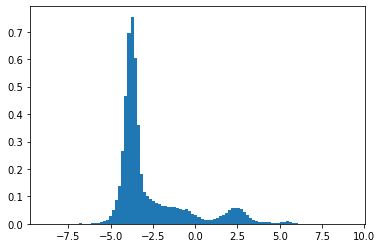

In [49]:
density = plt.hist(theta, bins=100, density=True)

In [57]:
rating_em = {}
for player_id in df_test['player_id'].unique():
    weight = em_players[player_id] if player_id in em_players.keys() else np.mean(list(em_players.values()))
    predicted_proba = 1 / (1 + np.exp(-(weight + density[1][:100])))
    rating_score = predicted_proba @ density[0] * 1 / 100
    rating_em[player_id] = rating_score

In [58]:
mean_rating = np.mean(list(rating_em.values()))

def rate_team(team):
    output = []
    for player in team['teamMembers']:
        id = player['player']['id']
        player_rating = (1 - rating_em[id]) if id in rating_em.keys() else (1 - mean_rating)
        output.append(player_rating)
    if len(output) == 0:
        output = [1 - mean_rating]
    return 1 - reduce((lambda x, y: x * y), output)

In [59]:
spear_corr = []
kendel_corr = []

for id, teams in test_results.items():
    true_rating = np.array([team['position'] for team in teams])
    my_rating = [rate_team(team) for team in teams]
    my_rating = np.argsort(my_rating)[::-1]
    if not np.isnan(spearmanr(true_rating, my_rating).correlation):
        spear_corr.append(spearmanr(true_rating, my_rating).correlation)
    if not np.isnan(kendalltau(true_rating, my_rating).correlation):
        kendel_corr.append(kendalltau(true_rating, my_rating).correlation)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [61]:
print(f'Средняя корреляция Спирмена: {np.mean(spear_corr):.3f}')
print(f'Средняя корреляция Кендалла: {np.mean(kendel_corr):.3f}') # Выросло

Средняя корреляция Спирмена: 0.769
Средняя корреляция Кендалла: 0.591


# 5 Сложность турниров

По сути, theta представляет собой силу каждого игрока, так что сложность турниров можно определять по средней силе игроков.

In [79]:
mean_rating = np.mean(list(rating.values()))
tournaments_diff = {}
for id, teams in train_results.items():
    tournament_rating = []
    for team in teams:
        for player in team['teamMembers']:
            player_id = player['player']['id']
            rating_player = player_rating = (1 - rating[player_id]) if player_id in rating.keys() else (1 - mean_rating)
            tournament_rating.append(rating_player)
    tournaments_diff[id] = np.mean(tournament_rating)

In [80]:
sorted_tours = {k: v for k, v in sorted(tournaments_diff.items(), key=lambda item: item[1], reverse=True)}

In [81]:
print('top 10:')
for i in range(10):
    id = list(sorted_tours.keys())[i]
    tour = tournaments[int(id)]
    print(f'{i}. {tour["name"]}')

top 10:
0. Открытый Студенческий чемпионат Краснодарского края
1. ЧГК-Баттл: 5К vs ИКО
2. Этажи
3. Открытый чемпионат Швейцарии
4. Бесславный Синхрон
5. Студенческий чемпионат Калининградской области
6. Открытая лига КФУ
7. Кубок Губернатора Мурманской области
8. Чемпионат Таджикистана
9. Осенний кубок Барнаула


# 6. Бонус. Рейтинг игроков.



In [82]:
sorted_rating = {k: v for k, v in sorted(rating_em.items(), key=lambda item: item[1], reverse=True)}

In [92]:
for i, each in enumerate(top_10_id):
    number_matches = len(df_train[df_train['player_id'] == each])
    print(f"{i+1}. {players[each]['name']} {players[each]['surname']}: {number_matches} answered questions")

1. София Лебедева: 36 answered questions
2. Илья Микулин: 36 answered questions
3. Ксения Гаврилова: 36 answered questions
4. Полина Джегур: 36 answered questions
5. Татьяна Дианова: 36 answered questions
6. Татьяна Косарева: 36 answered questions
7. Ольга Бондаренко: 36 answered questions
8. Сергей Пашкевич: 36 answered questions
9. Алексей Макаров: 36 answered questions
10. Полина Максимов: 36 answered questions


Все игроки из топа сыграли только 1 игру.